# IFSC Analysis
## Import Libraries & Tools

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import re

import seaborn as sns
import cufflinks as cf
import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

## Setting Up Directory Structure

In [2]:
DATA_DIR = os.path.join(
    os.path.dirname(os.path.realpath("__file__")), "data"
)

BOULDER_MEN_DIR   = os.path.join(DATA_DIR, "Boulder/Men")
BOULDER_WOMEN_DIR = os.path.join(DATA_DIR, "Boulder/Women")

## Helper Functions

In [3]:
def clean_boulder(df):
    """
    Returns a dataframe where each score has been broken out
    into multiple columns for easier manipulation.
    
    df: dataframe containing results for all bouldering events
    """
    # Gets tops and zones for qualifications
    df[['Q_Top', 'Q_Zone']] = df['Qualification'].str.split('T', expand=True)
    df['Q_Zone'] = df['Q_Zone'].str.split('Z', expand=True)[0]
    df[['Qualification', 'Q_Top_Att', 'Q_Zone_Att']] = df['Qualification'].str.split(expand=True)

    # Gets tops and zones for semi-finals
    df[['S_Top', 'S_Zone']] = df['Semi-Final'].str.split('T', expand=True)
    df['S_Zone'] = df['S_Zone'].str.split('Z', expand=True)[0]
    df[['Semi-Final', 'S_Top_Att', 'S_Zone_Att']] = df['Semi-Final'].str.split(expand=True)

    # Gets tops and zones for finals
    df[['F_Top', 'F_Zone']] = df['Final'].str.split('T', expand=True)
    df['F_Zone'] = df['F_Zone'].str.split('Z', expand=True)[0]
    df[['Final', 'F_Top_Att', 'F_Zone_Att']] = df['Final'].str.split(expand=True)

    new_cols = ['Q_Top', 'Q_Zone', 'Q_Top_Att', 'Q_Zone_Att',
                'S_Top', 'S_Zone', 'S_Top_Att', 'S_Zone_Att',
                'F_Top', 'F_Zone', 'F_Top_Att', 'F_Zone_Att']

    # Convert all new columns to int
    for col in new_cols:
        df[col] = df[col].astype('float', errors = 'ignore')

    return df

# Function to correct the old scoring syntax
def convert_score(score):
    """
    Returns a new string representing the converted score.
    Old syntax: xTw yBz
    New syntax: xTyZ w x
    x,y,w,z: number of attempts
    T, B/Z: tops & zones, respectively
    
    score: string representation of climber's results
    """
    if score:
        tmp = str(score)
        if 'b' in tmp.lower():
            tops, top_att = tmp.lower().split()[0].split('t')
            zones, zone_att = tmp.lower().split()[1].split('b')

            new_score = tops + 'T' + zones + 'Z ' + top_att + ' ' + zone_att
            return new_score
        return score
    return score

# Function to display a single climber's results
def check_climber(df, name):
    """
    Returns a dataframe showing results for each event for given
    climber.
    
    df: dataframe containing results for all bouldering events
    name: name of climber you want to examine
    """
    name = name.upper()
    individual = df.groupby(df['Name']).get_group(name)
    return individual

# Function to show the count of a climber's round appearances
def count_round_appearances(df, name):
    """
    Prints a count of the number of times a climber has made it
    to a specific round.
    
    df: df containing results from all scraped events
    name: name of climber you want to examine
    """
    name = name.upper()
    # Gets number of time climber appeared for each round
    q = df.groupby(df['Name']).get_group(name).count()['Qualification']
    s = df.groupby(df['Name']).get_group(name).count()['Semi-Final']
    f = df.groupby(df['Name']).get_group(name).count()['Final']
    
    print(f'{name} appearances:')
    print(f'{"Qualification round:" :>20} {q :>3}')
    print(f'{"Semi-Final round:" :>20} {s :>3}')
    print(f'{"Final round:" :>20} {f :>3}')
    
def get_bouldering_results(directory):
    """
    Combines all .csv files in given directory into a single dataframe.
    
    directory: directory containing all the .csv files
    """
    # Grabs all .csv files in given directory and combine into dataframe
    all_files = glob.glob(os.path.join(directory, "*.csv"))
    df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
    
    # Clean up some column/datatype issues
    df['Year'] = df['Event'].apply(lambda x: re.search("(\d{4})", x).group(1)) # Gets year of event
    df['Event'] = df['Event'].str.replace('IFSC - C', 'IFSC C').str.replace('Worldcup', 'World Cup')
    df['Rank'] = df['Rank'].fillna(-1).astype('int') # Fixes DNS rank
    df['Qualification'] = df['Qualification'].apply(convert_score) # Fixes old scoring syntax
    df['Semi-Final'] = df['Semi-Final'].apply(convert_score)
    df['Final'] = df['Final'].apply(convert_score)
    return df

## Import Scraped Data

In [4]:
boulder_men_all_results = get_bouldering_results(BOULDER_MEN_DIR)
boulder_men_all_results

,Event,ID,Rank,Name,Country,Qualification,Semi-Final,Final,Year
0,IFSC Climbing World Cup (B) - Hall (AUT) 2007,1204,1,KILIAN FISCHHUBER,AUT,6T6Z 11 9,4T4Z 11 8,4T4Z 8 5,2007
1,IFSC Climbing World Cup (B) - Hall (AUT) 2007,3577,2,JORG VERHOEVEN,NED,5T6Z 9 10,3T4Z 5 4,4T4Z 9 5,2007
2,IFSC Climbing World Cup (B) - Hall (AUT) 2007,4783,3,AKITO MATSUSHIMA,JPN,3T6Z 4 15,3T3Z 10 3,2T2Z 7 4,2007
3,IFSC Climbing World Cup (B) - Hall (AUT) 2007,1213,4,DAVID LAMA,AUT,4T6Z 7 9,3T4Z 7 8,2T4Z 8 10,2007
4,IFSC Climbing World Cup (B) - Hall (AUT) 2007,849,5,GABRIELE MORONI,ITA,4T5Z 11 11,3T4Z 5 5,1T3Z 3 4,2007
...,...,...,...,...,...,...,...,...,...
7786,"IFSC Climbing World Cup (B,S) - Seoul (KOR) 2022",3665,48,LUKE GOH WEN BIN,SGP,0T1Z 0 2,NaN,NaN,2022
7787,"IFSC Climbing World Cup (B,S) - Seoul (KOR) 2022",11859,48,DOHYEON KIM,KOR,0T1Z 0 2,NaN,NaN,2022
7788,"IFSC Climbing World Cup (B,S) - Seoul (KOR) 2022",2120,51,SUNGHOON PARK,KOR,0T1Z 0 5,NaN,NaN,2022
7789,"IFSC Climbing World Cup (B,S) - Seoul (KOR) 2022",13548,52,MUHAMMAD FERZA FERNADA ABDI,INA,0T0Z 0 0,NaN,NaN,2022


As we can see from the above, there are almost 7800 rows of data across *all* of the World Cup events we scraped earlier. If we want to look at the results of just a single climber, or perhaps get the number of times that climber appeared in each round of events, we can run the following functions.

In [5]:
individual = check_climber(boulder_men_all_results, 'jongwon chon')
individual.head(10)

,Event,ID,Rank,Name,Country,Qualification,Semi-Final,Final,Year
3049,"IFSC Climbing World Cup (B,S) - Chongqing (CHN...",2052,7,JONGWON CHON,KOR,3T5Z 4 18,1T3Z 2 6,NaN,2014
3117,IFSC Climbing World Championship (B) - Munich ...,2052,35,JONGWON CHON,KOR,2T4Z 7 7,NaN,NaN,2014
3198,"IFSC Climbing World Cup (L, B, S) - Haiyang (C...",2052,4,JONGWON CHON,KOR,4T5Z 5 7,1T2Z 3 3,0T2Z 4,2014
3234,IFSC Climbing World Cup (B) - Laval (FRA) 2014,2052,15,JONGWON CHON,KOR,5T5Z 10 9,2T3Z 3 4,NaN,2014
3292,IFSC Climbing World Cup (B) - Vail (USA) 2014,2052,16,JONGWON CHON,KOR,3T4Z 5 5,2T3Z 7 6,NaN,2014
3530,IFSC Climbing World Cup (B) - Toronto (CAN) 2014,2052,4,JONGWON CHON,KOR,3T5Z 8 10,3T4Z 5 7,2T3Z 7 10,2014
3570,IFSC Climbing World Cup (B) - Munich (GER) 2015,2052,3,JONGWON CHON,KOR,3T5Z 4 12,3T3Z 7 6,1T3Z 1 5,2015
3693,"IFSC Climbing World Cup (B,S) - Chongqing (CHN...",2052,2,JONGWON CHON,KOR,5T5Z 6 6,4T4Z 6 6,3T3Z 5 3,2015
3748,"IFSC Climbing World Cup (B,S) - Haiyang (CHN) ...",2052,1,JONGWON CHON,KOR,5T5Z 6 6,3T4Z 3 4,2T2Z 3 2,2015
3833,IFSC Climbing World Cup (B) - Vail (USA) 2015,2052,33,JONGWON CHON,KOR,3T3Z 5 4,NaN,NaN,2015


In [6]:
count_round_appearances(boulder_men_all_results, 'jongwon chon')

JONGWON CHON appearances:
Qualification round:  46
   Semi-Final round:  41
        Final round:  25


# Climber Statistics
## Individual Climber Results

Now we can look at the entirety of the results for men's bouldering (the exact same process can be followed for women's bouldering). The following function first checks to see if we have a .csv file that contains all of the data already. If we do, it loads it. If not, then it creates a new one - though it does take some time because it does require a complete scrape of the IFSC site to try and get each climber's height.

In [7]:
def get_bouldering_stats(df, category='men'):
    """
    Returns a dataframe showing the top 3 climbers (if applicable)
    grouped by country.
    
    df: dataframe containing aggregated results for each unique climber
    category: men's or women's category
    """
    # Checks if we've already created this file
    if category.lower() == 'men':
        csv = 'boulder_stats_men.csv'
    else:
        csv = 'boulder_stats_women.csv'
    
    file = DATA_DIR + '\\' + csv
    print(f'Checking to see if {csv} exists...')
        
    if os.path.exists(file):
        print(f'File found! Loading {csv}...')
        return pd.read_csv(file, index_col = 0)
    
    print('File does not exist - creating it now...')
    
    # Create a new dataframe with athlete's ID, name, and country
    clean_df = df.drop_duplicates(subset=['Name', 'ID'])[['ID', 'Name', 'Country']]

    # Counts number of appearances per round per climber
    qual_all = df.groupby(['ID', 'Name'])['Qualification'].count()
    semi_app = df.groupby(['ID', 'Name'])['Semi-Final'].count()
    final_app = df.groupby(['ID', 'Name'])['Final'].count()

    # Merges the above dataframes
    rounds = pd.merge(pd.merge(qual_all, semi_app , left_on=['ID', 'Name'], right_index=True), final_app, left_on=['ID', 'Name'], right_index=True)
    clean_df = pd.merge(clean_df, rounds, left_on=['ID', 'Name'], right_index=True)

    # Calculates percentages of appearances in each round
    clean_df['Q_Pct'] = round((clean_df['Qualification'] / clean_df['Qualification']) * 100, 2)
    clean_df['S_Pct'] = round((clean_df['Semi-Final'] / clean_df['Qualification']) * 100, 2)
    clean_df['F_Pct'] = round((clean_df['Final'] / clean_df['Qualification']) * 100, 2)
    clean_df = clean_df.sort_values('Final', ascending=False).reset_index(drop=True)

    # Convert 'ID' to string so we can scrape site for heights (~33 minutes)
    print(f'Gathering {category}\'s height - please be patient...')
    clean_df['ID'] = clean_df['ID'].apply(str)
    scraper = IFSCScraper()
    clean_df['Height'] = clean_df['ID'].apply(lambda x: scraper.get_athlete_height(x))
    scraper.end_session()

    # Saves data so we don't have to scrape later    
    clean_df.to_csv(file)
    print('...Done!')
    
    return clean_df

boulder_men_stats = get_bouldering_stats(boulder_men_all_results, 'men')

# Number of climbers that have a height listed on the IFSC site
have_height_men = (~boulder_men_stats['Height'].str.contains('-')).sum()
no_height_men = (boulder_men_stats['Height'].str.contains('-')).sum()
print(f'Only {have_height_men} male climbers ({(have_height_men/no_height_men)*100:.2f}%) have their height listed!')

boulder_men_stats

Checking to see if boulder_stats_men.csv exists...
File found! Loading boulder_stats_men.csv...
Only 153 male climbers (13.32%) have their height listed!


,ID,Name,Country,Qualification,Semi-Final,Final,Q_Pct,S_Pct,F_Pct,Height
0,1204,KILIAN FISCHHUBER,AUT,56,51,44,100.0,91.07,78.57,-
1,53,DMITRII SHARAFUTDINOV,RUS,65,53,40,100.0,81.54,61.54,-
2,60,RUSTAM GELMANOV,RUS,69,56,38,100.0,81.16,55.07,-
3,2272,KOKORO FUJII,JPN,54,48,27,100.0,88.89,50.00,176
4,79,ALEKSEY RUBTSOV,RUS,57,50,26,100.0,87.72,45.61,178
...,...,...,...,...,...,...,...,...,...,...
1297,6063,DAVID WETMORE,USA,2,0,0,100.0,0.00,0.00,-
1298,1736,AUSTIN GEIMAN,USA,15,1,0,100.0,6.67,0.00,-
1299,6081,WOLTER WESTDIJK,NED,1,0,0,100.0,0.00,0.00,-
1300,6080,MELLE VROOM,NED,1,0,0,100.0,0.00,0.00,-


As you can see from the above, from our original ~7800 rows, we have condensed it down to 1302 unique male climbers. Along with their respective countries of origin, you can see the number of times each climber appeared in the qualification, semi-final, and final rounds. Additionally, you can see a percentage of times the climber reached that specific round. We're not done yet however, as there is still some important information we can figure out.

## Podium Count
How many times did each climber reach the podium? How many Bronze, Silver, or Gold medals did they get? Now that we have all of the data in a single dataframe, we can find out! To do this, we can use the [.groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) method, as well as a clever use of the [.size](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.size.html?highlight=size#pandas.core.groupby.DataFrameGroupBy.size) and [.unstack](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.unstack.html?highlight=unstack#pandas.DataFrame.unstack) methods.

In [8]:
def calculate_podiums(all_df, stats_df, country = False):
    """
    Returns a dataframe showing each unique climber's aggregated
    results across all scraped events, including # of times they
    earned a podium position.
    
    all_df: dataframe containing all non-aggregated results
    stats_df: dataframe containing aggregated results for all unique climbers
    """
    # Get a dataframe of all climbers who had a rank of 1, 2, or 3 in any event
    podiums = all_df[(all_df['Rank'] <= 3) & (all_df['Rank'] > 0)]

    # Get another new dataframe with the count of occurences each climber got each rank
    if country:
        medals = podiums.groupby(['Rank', 'Country']).size().unstack(0)
    else:
        medals = podiums.groupby(['ID', 'Name', 'Rank']).size().unstack()
    medals = medals.rename(columns={-1: 'Podium', 1: 'Gold', 2: 'Silver', 3: 'Bronze'})
    medals['Podium'] = medals['Gold'] + medals['Silver'] + medals['Bronze']

    # Merge with our stats dataframe and add new % columns
    if country:
        stats_df           = stats_df.merge(medals, how='left', left_on=['Country'], right_on=['Country']).fillna(0)
    else:
        stats_df           = stats_df.merge(medals, how='left', left_on=['ID', 'Name'], right_on=['ID', 'Name']).fillna(0)
    stats_df['P_Pct']      = round((stats_df['Podium'] / stats_df['Qualification']) * 100, 2)
    stats_df['Gold_Pct']   = round((stats_df['Gold'] / stats_df['Qualification']) * 100, 2)
    stats_df['Silver_Pct'] = round((stats_df['Silver'] / stats_df['Qualification']) * 100, 2)
    stats_df['Bronze_Pct'] = round((stats_df['Bronze'] / stats_df['Qualification']) * 100, 2)
    
    # Convert these columns to 'int'
    int_col = ['Podium', 'Bronze', 'Silver', 'Gold']
    stats_df[int_col] = stats_df[int_col].astype(int)

    # Reordering the columns into a more logical format
    if country:
        cols = ['Country', 'Qualification', 'Semi-Final', 'Final', 'Podium',
                'Bronze', 'Silver', 'Gold', 'Q_Pct', 'S_Pct', 'F_Pct', 'P_Pct',
                'Bronze_Pct', 'Silver_Pct', 'Gold_Pct']
    else:
        cols = ['ID', 'Name', 'Country', 'Height', 'Qualification', 'Semi-Final',
                'Final', 'Podium', 'Bronze', 'Silver', 'Gold', 'Q_Pct', 'S_Pct',
                'F_Pct', 'P_Pct', 'Bronze_Pct', 'Silver_Pct', 'Gold_Pct']

    stats_df = stats_df[cols]
    return stats_df

boulder_men_stats = calculate_podiums(boulder_men_all_results, boulder_men_stats)
boulder_men_stats

,ID,Name,Country,Height,Qualification,Semi-Final,Final,Podium,Bronze,Silver,Gold,Q_Pct,S_Pct,F_Pct,P_Pct,Bronze_Pct,Silver_Pct,Gold_Pct
0,1204,KILIAN FISCHHUBER,AUT,-,56,51,44,35,10,8,17,100.0,91.07,78.57,62.50,17.86,14.29,30.36
1,53,DMITRII SHARAFUTDINOV,RUS,-,65,53,40,26,3,9,14,100.0,81.54,61.54,40.00,4.62,13.85,21.54
2,60,RUSTAM GELMANOV,RUS,-,69,56,38,19,7,6,6,100.0,81.16,55.07,27.54,10.14,8.70,8.70
3,2272,KOKORO FUJII,JPN,176,54,48,27,0,3,0,6,100.0,88.89,50.00,0.00,5.56,0.00,11.11
4,79,ALEKSEY RUBTSOV,RUS,178,57,50,26,14,10,1,3,100.0,87.72,45.61,24.56,17.54,1.75,5.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,6063,DAVID WETMORE,USA,-,2,0,0,0,0,0,0,100.0,0.00,0.00,0.00,0.00,0.00,0.00
1298,1736,AUSTIN GEIMAN,USA,-,15,1,0,0,0,0,0,100.0,6.67,0.00,0.00,0.00,0.00,0.00
1299,6081,WOLTER WESTDIJK,NED,-,1,0,0,0,0,0,0,100.0,0.00,0.00,0.00,0.00,0.00,0.00
1300,6080,MELLE VROOM,NED,-,1,0,0,0,0,0,0,100.0,0.00,0.00,0.00,0.00,0.00,0.00


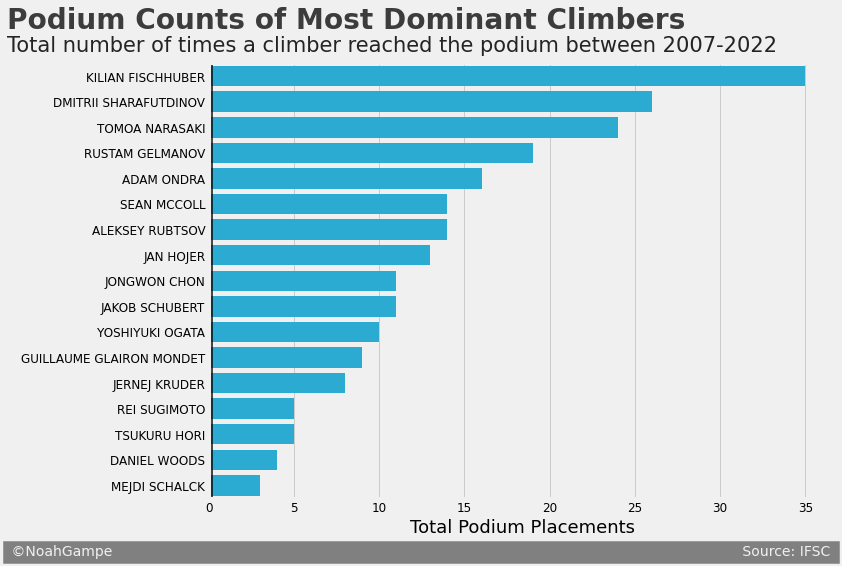

In [9]:
def plot_bar(df, col, col2, title, sub, xoffset, yoffset, sig):
    #figure details
    fig = plt.figure(figsize=(10,8), facecolor='#f0f0f0')
            
    #plot
    ax = sns.barplot(data=df, x=col, y=col2, color='#10baee')
    # for i in ax.containers:
    #     ax.bar_label(i,)
    
    #styling
    #blue = #10baee
    #pink = #ff007e
    
    # ax.axhline(y = 0, color = "black", linewidth = 2, alpha = .7)
    ax.axvline(x = 0.2, color = "black", linewidth = 2, alpha = .7)
    ax.set_xlabel('Total Podium Placements', fontsize=18)
    ax.yaxis.label.set_visible(False)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
    #title & subtitle
    ax.text(xoffset,0.94, s=title, fontsize=28, weight="bold", alpha=.75, transform=fig.transFigure)
    ax.text(xoffset,0.9, s=sub, fontsize=21, alpha=.85, transform=fig.transFigure)
    
    #signature bar
    ax.text(x=xoffset, y=yoffset,
            s=" ©NoahGampe" + ' '*sig + "Source: IFSC ",
            fontsize=14, color="#f0f0f0", backgroundcolor="grey", transform=fig.transFigure)
    
    plt.show()
    
title = "Podium Counts of Most Dominant Climbers"
sub = "Total number of times a climber reached the podium between 2007-2022"
plot_bar(boulder_men_stats[boulder_men_stats['Podium'] > 0].sort_values('Podium',ascending=False), 'Podium', 'Name', title, sub, -0.2, 0.025, 140)

Now we have a more robust dataframe with more relevant information. Additionally, we can use this dataframe with our previous function to check out a single climber and see all their stats. A reminder that these stats only represent the IFSC World Cup events.

In [10]:
individual2 = check_climber(boulder_men_stats, 'jongwon chon')
individual2

,ID,Name,Country,Height,Qualification,Semi-Final,Final,Podium,Bronze,Silver,Gold,Q_Pct,S_Pct,F_Pct,P_Pct,Bronze_Pct,Silver_Pct,Gold_Pct
6,2052,JONGWON CHON,KOR,177,46,41,25,11,3,3,5,100.0,89.13,54.35,23.91,6.52,6.52,10.87


## Country Statistics

In [11]:
def get_bouldering_country_stats(df):
    """
    Returns a dataframe showing results of all scraped IFSC events
    grouped by country.
    
    df: dataframe containing results for all bouldering events
    """
    clean_df = pd.DataFrame()
    clean_df['Country'] = df['Country'].unique()

    # Counts number of appearances per round per country
    qual_all = df.groupby(['Country'])['Qualification'].count()
    semi_app = df.groupby(['Country'])['Semi-Final'].count()
    final_app = df.groupby(['Country'])['Final'].count()

    # Merges the above with our previous dataframe
    clean_df = pd.merge(pd.merge(qual_all, semi_app , left_on='Country', right_index=True),
                  final_app, left_on='Country', right_index=True)

    # Calculates percentages of appearances vs total events
    clean_df = clean_df.sort_values('Final', ascending=False).reset_index()
    clean_df['Q_Pct'] = round((clean_df['Qualification'] / clean_df['Qualification'].sum()) * 100, 2)
    clean_df['S_Pct'] = round((clean_df['Semi-Final'] / clean_df['Semi-Final'].sum()) * 100, 2)
    clean_df['F_Pct'] = round((clean_df['Final'] / clean_df['Final'].sum()) * 100, 2)
    return clean_df

boulder_men_country_stats = get_bouldering_country_stats(boulder_men_all_results)
boulder_men_country_stats

,Country,Qualification,Semi-Final,Final,Q_Pct,S_Pct,F_Pct
0,JPN,651,386,134,8.36,18.15,20.43
1,RUS,425,197,109,5.46,9.26,16.62
2,FRA,628,299,81,8.06,14.06,12.35
3,AUT,390,142,75,5.01,6.68,11.43
4,GER,495,180,38,6.35,8.46,5.79
...,...,...,...,...,...,...,...
75,IRL,33,1,0,0.42,0.05,0.00
76,ARG,33,0,0,0.42,0.00,0.00
77,KAZ,32,0,0,0.41,0.00,0.00
78,KGZ,1,0,0,0.01,0.00,0.00


We can then re-configure our previous function that calculated podium results for individual climbers for countries.

In [12]:
country_stats = calculate_podiums(boulder_men_all_results, boulder_men_country_stats, True)
country_stats

,Country,Qualification,Semi-Final,Final,Podium,Bronze,Silver,Gold,Q_Pct,S_Pct,F_Pct,P_Pct,Bronze_Pct,Silver_Pct,Gold_Pct
0,JPN,651,386,134,66,20,25,21,8.36,18.15,20.43,10.14,3.07,3.84,3.23
1,RUS,425,197,109,62,22,17,23,5.46,9.26,16.62,14.59,5.18,4.00,5.41
2,FRA,628,299,81,24,10,7,7,8.06,14.06,12.35,3.82,1.59,1.11,1.11
3,AUT,390,142,75,51,18,11,22,5.01,6.68,11.43,13.08,4.62,2.82,5.64
4,GER,495,180,38,20,7,5,8,6.35,8.46,5.79,4.04,1.41,1.01,1.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,IRL,33,1,0,0,0,0,0,0.42,0.05,0.00,0.00,0.00,0.00,0.00
76,ARG,33,0,0,0,0,0,0,0.42,0.00,0.00,0.00,0.00,0.00,0.00
77,KAZ,32,0,0,0,0,0,0,0.41,0.00,0.00,0.00,0.00,0.00,0.00
78,KGZ,1,0,0,0,0,0,0,0.01,0.00,0.00,0.00,0.00,0.00,0.00


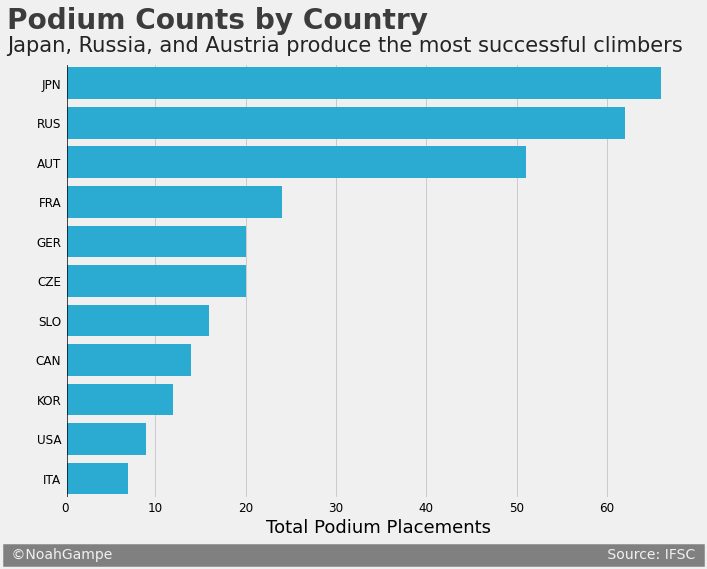

In [13]:
title = "Podium Counts by Country"
sub = "Japan, Russia, and Austria produce the most successful climbers"
plot_bar(country_stats[country_stats['Podium'] > 0].sort_values('Podium',ascending=False), 'Podium', 'Country', title, sub, 0, 0.02, 110)

## Country Performance Over Time

Which countries had the strongest performance over time? We can create a new dataframe, one that shows the number of times a climber from a given country reached the final round of a world cup event per year. According to [section 8.6 of the IFSC Rules](https://cdn.ifsc-climbing.org/images/Website/2023_IFSC_Rules_112.pdf), the quota for the Final round shall be six (6) climbers. To properly view all climbers who made it to the final round, we shall be looking at all climbers who have a rank less than or equal to 6.

In [14]:
def get_country_yearly_stats(df):
    """
    Returns df containing number of times a country has been represented in the finals.
    
    df: dataframe containing results for all bouldering events
    """
    stats_df = df[(df['Rank'] <= 6) & (df['Rank'] > 0)] # Removes any -1 or 'DNS' competitors
    # stats_df = stats_df.groupby(['Country', 'Year']).size().unstack().fillna(0).astype('int8').reset_index() # Works
    stats_df = stats_df.groupby(['Year'])['Country'].value_counts().unstack().fillna(0).astype('int')#.reset_index() was using this one for plotly
    return stats_df
    
country_perf = get_country_yearly_stats(boulder_men_all_results)
country_perf.head()

Country,AUS,AUT,BEL,CAN,CFR,CZE,FIN,FRA,GBR,GER,...,JPN,KOR,LAT,NED,POL,RUS,SLO,SUI,UKR,USA
Year,,,,,,,,,,,,,,,,,,,,,
2007,0,9,0,0,0,3,2,8,2,1,...,3,1,0,3,0,8,0,2,2,0
2008,0,10,0,2,0,0,0,6,1,1,...,3,0,0,1,0,7,1,0,2,3
2009,0,4,0,1,0,1,0,5,2,2,...,1,0,0,0,0,4,2,0,2,3
2010,0,6,0,1,0,6,0,3,2,0,...,5,0,0,1,0,9,2,3,2,1
2011,1,10,0,1,0,0,0,10,1,2,...,4,0,0,2,0,15,4,1,1,2


The above dataframe contains the number of finalists per country, per year. We will make a visualization of this in a second. We can sum up the totals over all the years to see which country produces the most IFSC World Cup finalists.

In [15]:
total_finalists = country_perf.sum().sort_values(ascending=False)
total_finalists.head()

Country
JPN    133
RUS    106
FRA     77
AUT     74
GER     37
dtype: int64

In [16]:
def plot_line(df, title, sub, xoffset, yoffset, sig, subset=[]):
    #figure details
    fig = plt.figure(figsize=(14,12), facecolor='#f0f0f0')
       
    #plot details
    if subset:
        palette = ['#4167a6', '#9d65b4', '#ea5c97','#ff715d' ,'#ffa600']
        ax = sns.lineplot(data=df[subset], linewidth=3.0, dashes=False, palette=palette[:len(subset)]) #displays only subset
        ax = sns.lineplot(data=df.drop(subset, axis=1), linewidth=3.0, alpha=0.2)
    else:
        ax = sns.lineplot(data=df, linewidth=3.0) #displays each country equally
    
    # ax = sns.lineplot(data=df.drop(['JPN', 'RUS', 'AUT'], axis=1), linewidth=3.0, alpha=0.2)
    ax.axhline(y = 0, color = "black", linewidth = 4, alpha = .7)
    ax.legend(fontsize = 14, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
    #title & subtitle
    ax.text(xoffset, 0.93, s=title, fontsize=28, weight="bold", alpha=.75, transform=fig.transFigure)
    ax.text(xoffset, 0.9, s=sub, fontsize=21, alpha=.85, transform=fig.transFigure)
    
    #signature bar
    ax.text(x=xoffset, y=yoffset,
            s=" ©NoahGampe" + ' '*sig + "Source: IFSC ",
            fontsize=14, color="#f0f0f0", backgroundcolor="grey", transform=fig.transFigure)
    
    plt.show()
    
title = "Number of Finalists Per Country Over Time"
sub = "Japan begins to dominate after 2015, while Russia and France begin to fall behind"
# plot_line(country_perf, title, sub, 0.05, 0.055 ,160)
# plot_line(country_perf, title, sub, 0.05, 0.055 ,180, ['JPN', 'RUS', 'FRA'])

In [17]:
title="Number of Finalists Per Country Over Time <br><sup>Japan begins to dominate after 2015, while Russia and France fall behind"
years = [c for c in country_perf.index]
countries = [v for v in list(country_perf.columns)]

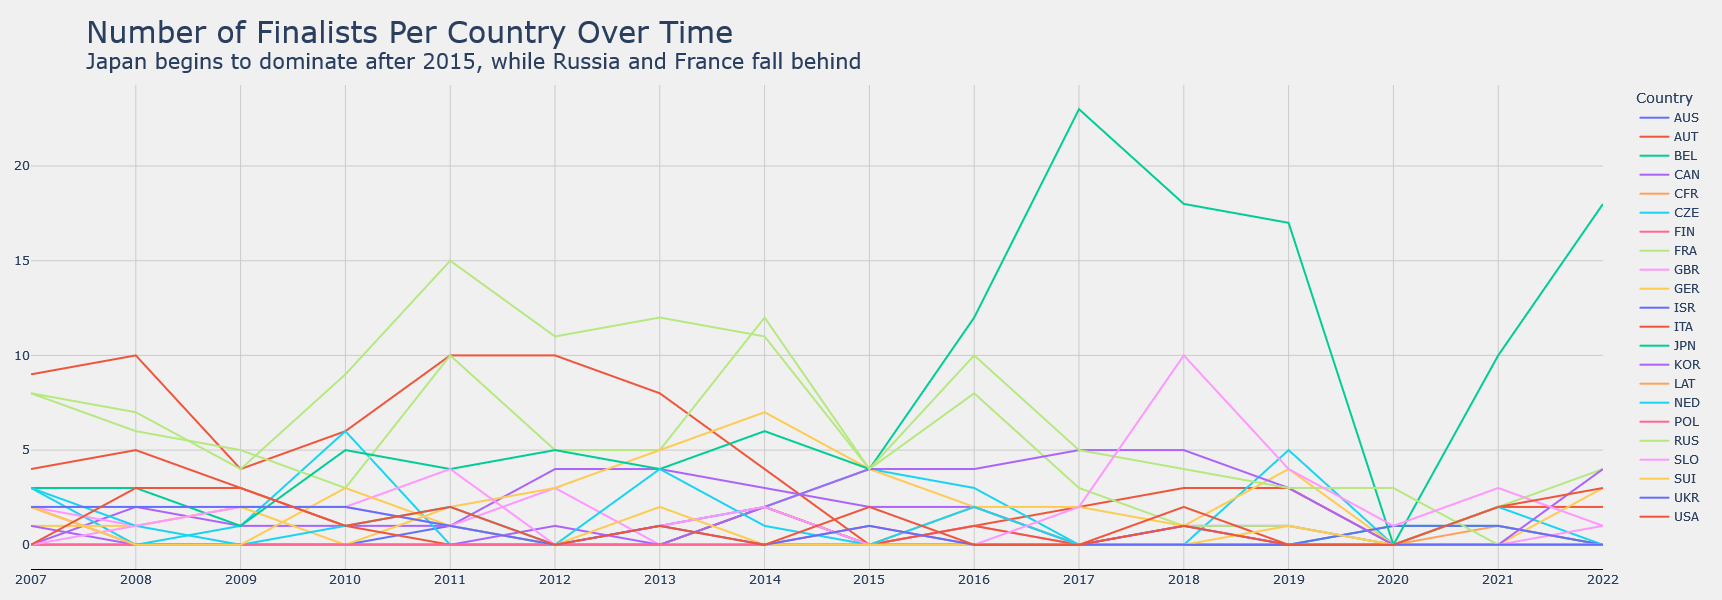

In [18]:
fig = px.line(country_perf,
              width=1000,
              height=600)
fig.update_layout(
    title = dict(text=title, font=dict(size=30)),
    plot_bgcolor = '#f0f0f0',
    paper_bgcolor = '#f0f0f0',
    yaxis_title = None,
    xaxis_title = None,
    margin=dict(l=25, r=25, t=85, b=25)
)
fig.update_xaxes(
    showline=True,
    linecolor='black',
    gridcolor='#cbcbcb'
)
fig.update_yaxes(
    showticklabels=True,
    gridcolor='#cbcbcb'
)

If we examine the above results, it's very clear that Japan and Russia dominate bouldering competitions (in terms of the number of times one of their climbers reached the finals). Fascinatingly, Japan has reached the finals round at least once per year for every single year except 2020 - which was right in the middle of the COVID-19 pandemic, when the [IFSC cancelled two competition events](https://www.ifsc-climbing.org/index.php/news/388-ifsc-world-cups-in-salt-lake-city-and-seoul-cancelled) due to health and safety concerns. This resulted in 2020 only have a *single* bouldering event for the entire season. That one event was the European Continental Championships, so non-Europeans weren't allowed to compete anyways!

## Top Climbers By Year

In [19]:
def get_top_by_year(df):
    """
    Returns a dataframe showing the top 5 climbers grouped by competition
    year, based on the number of times they reached the podium.
    
    df: dataframe containing results for all bouldering events
    """
    df = df[(df['Rank'] <= 3) & (df['Rank'] > 0)] # Only get climbers on podium
    df = df.groupby(['Year'])[['Name']].value_counts().to_frame(name = 'Podiums').reset_index() # Each climber's podium count by year    
    df = df.groupby(['Year'], sort=False).head(5).reset_index(drop = True).astype({'Year': 'int'}) # Top 5 climbers per year by podium count
    return df
    
top_by_year = get_top_by_year(boulder_men_all_results)
top_by_year[top_by_year['Year'] == 2022]

,Year,Name,Podiums
73,2022,YOSHIYUKI OGATA,5
74,2022,TOMOA NARASAKI,3
75,2022,MEJDI SCHALCK,2
76,2022,KOKORO FUJII,2
77,2022,YANNICK FLOHÉ,1


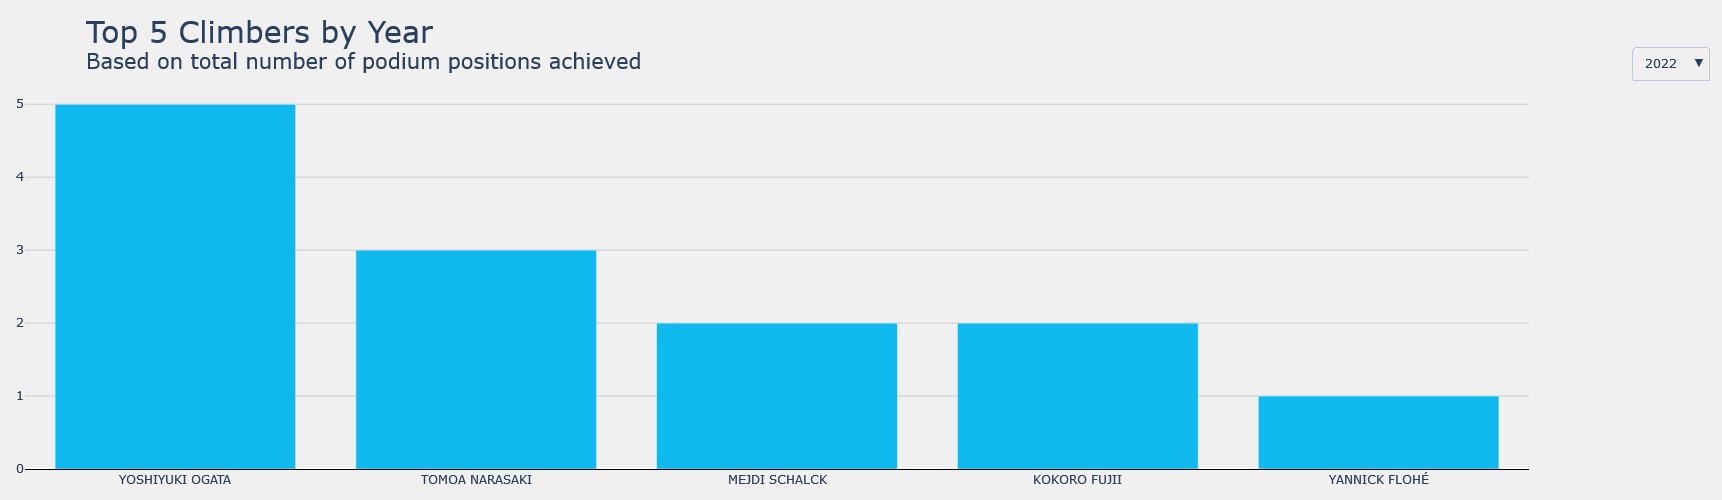

In [20]:
years = list(top_by_year['Year'].unique().astype(str))

# Creates dictionary of dataframes - one for each year
top5_dict = {}
for year in years:
    top5_dict[year] = top_by_year[top_by_year['Year'] == int(year)]

title = "Top 5 Climbers by Year<br><sup>Based on total number of podium positions achieved"

fig = go.Figure()

# Adds trace for each year to our graph object
for year in years:
    fig.add_trace(
        go.Bar(
            x = top5_dict[year]['Name'],
            y = top5_dict[year]['Podiums'],
            name = year,
            marker = dict(color = '#10baee'),
            visible = True if year == years[-1] else False
        )
    )

# Creates list of buttons for each year
buttons_opts = []
for i, year in enumerate(years):
    args = [False] * len(years)
    args[i] = True
    
    buttons_opts.append(
        dict(
            method = 'update',
            label = year,
            args = [{
                'visible': args, #this is the key line!
                'title': year,
                'showlegend': False
            }]
        )
    )

# Styling
fig.update_layout(
    updatemenus = [go.layout.Updatemenu(
        active = len(years)-1,
        buttons = buttons_opts,
        x = 1.12,
        xanchor = 'right',
        y = 1.1,
        yanchor = 'top'
        )],
    yaxis={ 
        'tickvals': [*range(0, 10)]
    },
    title = dict(text=title, font=dict(size=30)),
    width = 800,
    height = 500,
    plot_bgcolor = '#f0f0f0',
    paper_bgcolor = '#f0f0f0',
    yaxis_title = None,
    xaxis_title = None,
    margin=dict(l=25, r=25, t=85, b=25)
)

fig.update_xaxes(
    showline=True,
    linecolor='black',
    # gridcolor='#cbcbcb'
)

fig.update_yaxes(
    showticklabels=True,
    gridcolor='#cbcbcb'
)

## Top Climbers By Country

In [21]:
def get_top_by_country(df):
    """
    Returns a dataframe showing the top 3 climbers (if applicable)
    grouped by country.
    
    df: dataframe containing results for all bouldering events
    """
    df = df[(df['Rank'] <= 3) & (df['Rank'] > 0)] # Only get climbers on podium
    # df = df[df['Rank'] == 1] # Only get climbers who won gold
    df = df.groupby(['Country'])[['Name']].value_counts().to_frame(name = 'Podiums').reset_index() # Each climber's podium count by year    
    df = df.groupby(['Country'], sort=False).head().reset_index(drop = True) # Top 3 climbers per year by country
    return df
    
top_by_country = get_top_by_country(boulder_men_all_results)
top_by_country.head()

,Country,Name,Podiums
0,AUT,KILIAN FISCHHUBER,35
1,AUT,JAKOB SCHUBERT,11
2,AUT,DAVID LAMA,4
3,AUT,LUKAS ENNEMOSER,1
4,CAN,SEAN MCCOLL,14


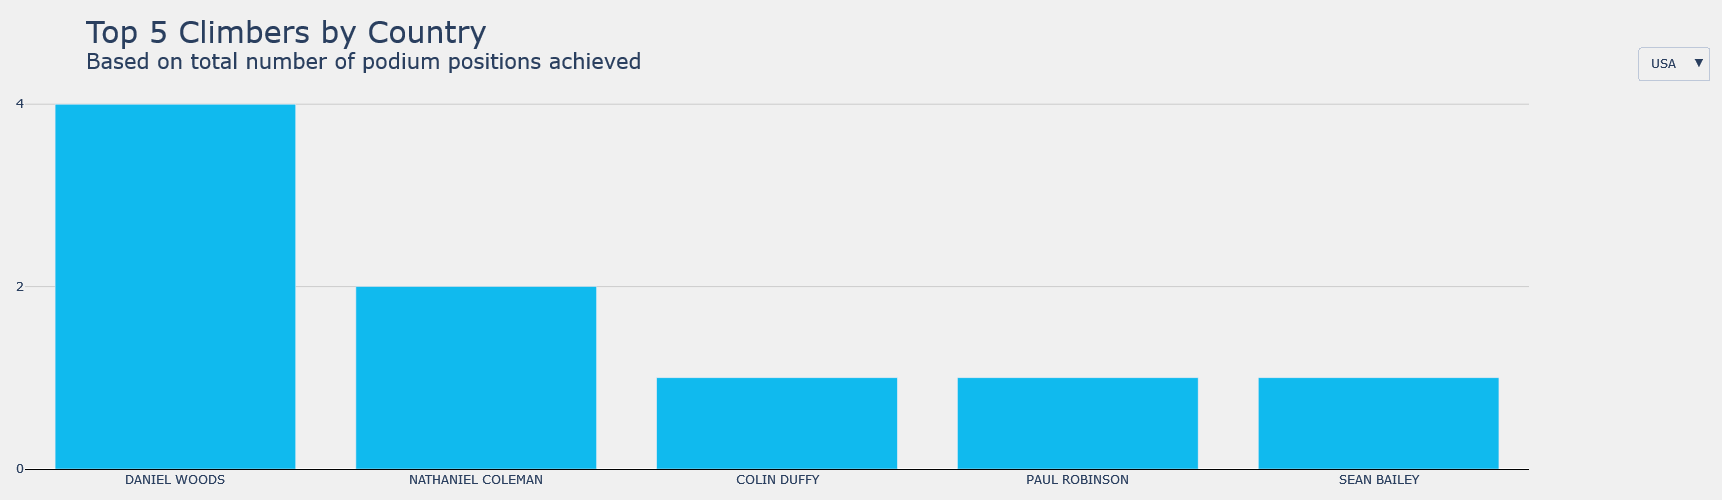

In [22]:
countries = list(top_by_country['Country'].unique())

# Creates dictionary of dataframes - one for each year
top5country_dict = {}
for country in countries:
    top5country_dict[country] = top_by_country[top_by_country['Country'] == country]

title = "Top 5 Climbers by Country<br><sup>Based on total number of podium positions achieved"

fig = go.Figure()

# Adds trace for each year to our graph object
for country in countries:
    fig.add_trace(
        go.Bar(
            x = top5country_dict[country]['Name'],
            y = top5country_dict[country]['Podiums'],
            name = country,
            marker = dict(color = '#10baee'),
            visible = True if country == countries[-1] else False
        )
    )

# Creates list of buttons for each year
buttons_opts = []
for i, country in enumerate(countries):
    args = [False] * len(countries)
    args[i] = True
    
    buttons_opts.append(
        dict(
            method = 'update',
            label = country,
            args = [{
                'visible': args, #this is the key line!
                'title': country,
                'showlegend': False
            }]
        )
    )

# Styling
fig.update_layout(
    updatemenus = [go.layout.Updatemenu(
        active = len(countries)-1,
        buttons = buttons_opts,
        x = 1.12,
        xanchor = 'right',
        y = 1.1,
        yanchor = 'top'
        )],
    yaxis={ 
        'tickvals': list(range(0,40,2))
    },
    title = dict(text=title, font=dict(size=30)),
    width = 800,
    height = 500,
    plot_bgcolor = '#f0f0f0',
    paper_bgcolor = '#f0f0f0',
    yaxis_title = None,
    xaxis_title = None,
    margin=dict(l=25, r=25, t=85, b=25)
)

fig.update_xaxes(
    showline=True,
    linecolor='black',
    # gridcolor='#cbcbcb'
)

fig.update_yaxes(
    showticklabels=True,
    gridcolor='#cbcbcb'
)